## Step 1: Download the base model and sample some images from it

Install all the Huggingface python packages

Set an environment variable for the base model to be fine-tuned

In [1]:
import os
import torch

os.environ['MODEL_NAME'] = 'stabilityai/stable-diffusion-2-1'

from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionUpscalePipeline
#from diffusers import DiffusionPipeline

#%env MODEL_NAME=stabilityai/stable-diffusion-2-1

Define a simple function to plot a list of images returned from the model when generating

In [2]:
def plot_images(images):
    from matplotlib import pyplot as plt
    plt.figure()
    f, axarr = plt.subplots(1, len(images), figsize=(20,10))
    for ax, img in zip(axarr.flatten(), images):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(os.getenv('MODEL_NAME'), torch_dtype=torch.float16)
pipe = pipe.to("cuda")

In [ ]:
prompt = "an isometric view of a skyscraper with the letter A on its side"
images = pipe(prompt, num_images_per_prompt=3).images

<Figure size 640x480 with 0 Axes>

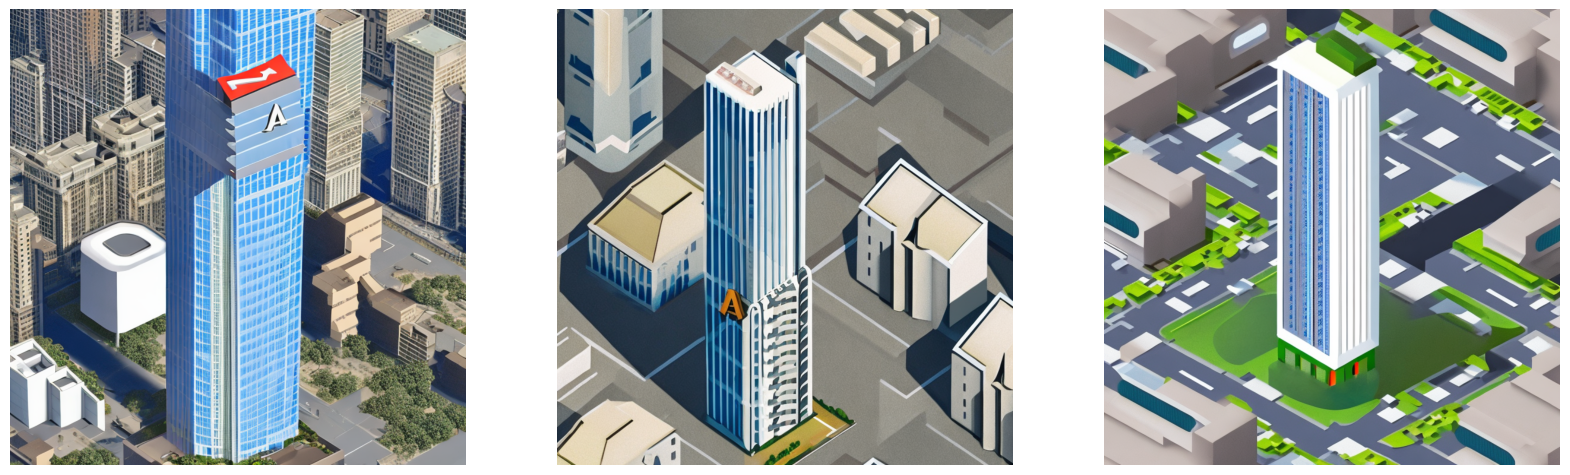

In [5]:
plot_images(images)

In [6]:
del pipe
del images

Import the relevant python libraries to load and sample from the Stable Diffusion model

In this step we initialise the model and move it to the GPU (you need to choose the correct runtime on google colab to run this command). This step will also trigger the download of the model. The model is a few GB, it might take some time but it will be faster than what you expect. 😏

We set the text prompt for generating the images and run the actual generation.

Let's plot the images from the base model with our function:

**IMPORTANT:** We need to free up the memory of the GPU to be able to start the actual training, let's delete the python variables and collect all the garbage using the garbage collector. Finally we use torch to empty the GPU memory

## Step 2: Fine-tune the model

Let's clone the dataset and the hugging face code which contains the finetuning script

In [ ]:
!git clone https://huggingface.co/datasets/gokaygokay/panorama_hdr_dataset
#!git clone https://huggingface.co/datasets/Loulblemo/diffusion_skyscrapers_city_building
!git clone https://github.com/huggingface/diffusers.git

Set some flags for the finetuning script, the dataset to be used and the number of iterations. Since the dataset we chose is small and we want to finetune quickly using the colab free tier, let's only finetune for 50 epochs

In [2]:
os.environ['dataset_name'] = 'gokaygokay/panorama_hdr_dataset'
#%env dataset_name=gokaygokay/panorama_hdr_dataset
#%env dataset_name=diffusion_skyscrapers_city_building
# No need to train the model for long to see meaningful results.

In [3]:
os.environ['max_training_epochs'] = '30'
#%env max_training_epochs = 15

In [4]:
from datasets import load_dataset
ds = load_dataset('gokaygokay/panorama_hdr_dataset')

train_set = ds['train']

In [5]:
print(train_set[0])

{'png_image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024 at 0x174927D0F50>, 'detail_mode1': 'A large room with a lot of dirt on the floor.', 'detail_mode2': 'The image shows an old building with a lot of dirt on the ground, walls, windows, and lights on the ceiling. At the bottom of the image, there is text.', 'detail_mode3': 'The image shows an empty room with a high ceiling and arched windows. The room appears to be abandoned and is covered in dirt and debris. The walls are made of brick and there are several large windows on the left side of the room, allowing natural light to enter. The floor is made of concrete and there is a large pile of rubble in the center of the space. The ceiling is arched and has several circular lights hanging from it. The overall atmosphere of the image is one of neglect and abandonment.'}


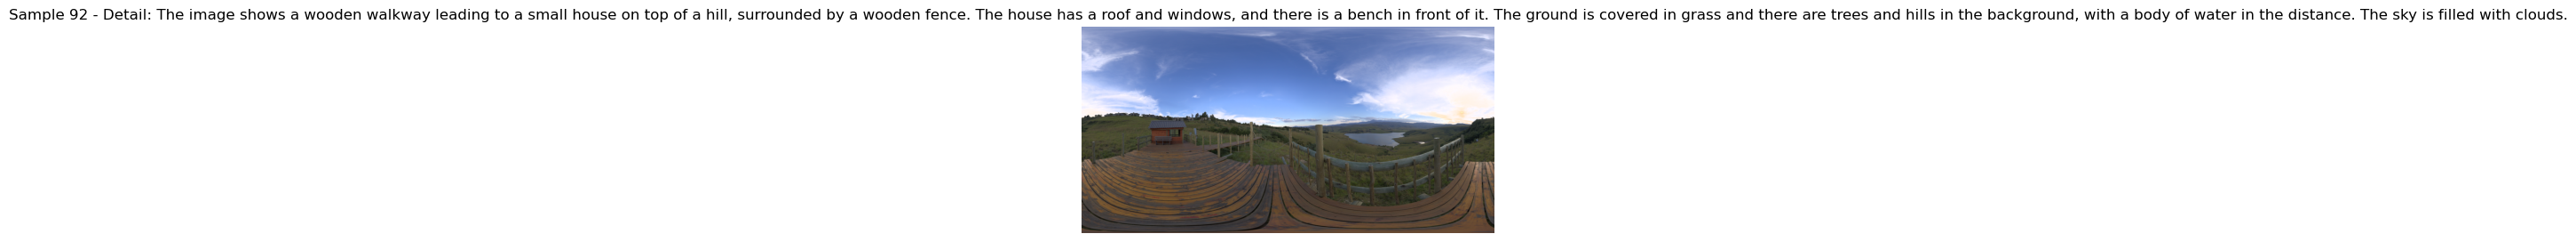

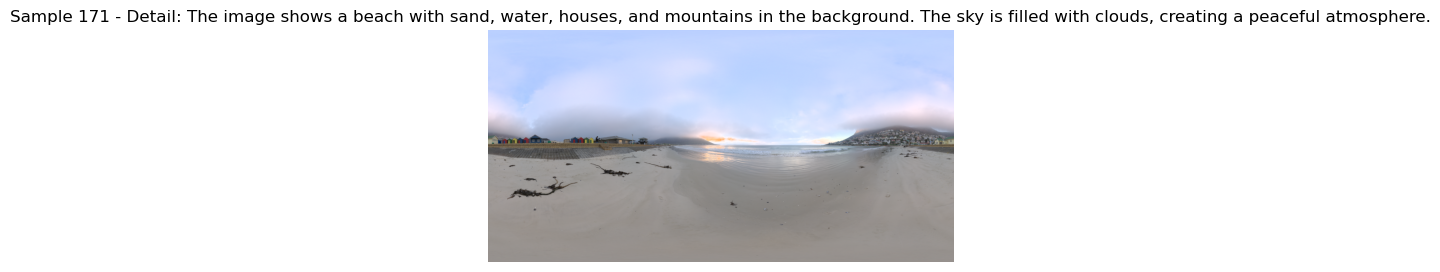

In [6]:
import random
import matplotlib.pyplot as plt
num_samples = 2
random_indices = random.sample(range(len(train_set)), num_samples)

for i in random_indices:
    sample = train_set[i]
    image = sample['png_image']  # Access the image using the correct key
    detail_label = sample['detail_mode2']  # Access the middle detail label

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Sample {i} - Detail: {detail_label}")
    plt.show()

In [7]:
del ds

Now we run the actual fine-tuning script. **IMPORTANT:** Remember if you want to train on google's free T4 GPU it's crucial to add the flag

```
--use_8bit_adam
```
We will save the model in the *city-building-model* folder


In [ ]:
# The --use_8bit_adam flag is crucial to be able to train on the T4 GPU which has only 15GB of memory
!accelerate launch diffusers/examples/text_to_image/train_text_to_image_lora.py \
--pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1" \
--dataset_name="everettshen/StreetView360AtoZ" \
--use_8bit_adam \
--resolution=1024 --center_crop --random_flip\
--train_batch_size=1 \
--mixed_precision="fp16" \
--gradient_accumulation_steps=4 \
--max_train_steps=20 \
--learning_rate=1e-06 \
--max_grad_norm=1 \
--lr_scheduler="cosine" --lr_warmup_steps=0 \
--output_dir="panoroma-equirctangular-model" \
--image_column="image" \
--caption_column="caption" \
--seed=42 
# command = f"""
# accelerate launch diffusers/examples/text_to_image/train_text_to_image_lora.py \
#   --pretrained_model_name_or_path={os.environ['MODEL_NAME']} \
#   --dataset_name={os.environ['dataset_name']} \
#   --use_8bit_adam \
#   --resolution=512 --center_crop \
#   --train_batch_size=1 \
#   --gradient_accumulation_steps=4 \
#   --gradient_checkpointing \
#   --mixed_precision="fp16" \
#   --max_train_steps={os.environ['max_training_epochs']} \
#   --learning_rate=1e-06 \
#   --max_grad_norm=1 \
#   --lr_scheduler="cosine" --lr_warmup_steps=0 \
#   --output_dir="panoroma-hdr-model" \
#   --image_column="png_image" \
#   --caption_column="detail_mode3"
# """

# os.system(command)

In [64]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Step 3: Sample from the finetuned model

We load the new model in the GPU (this time we don't need to Download anything as the fine-tuned model has been saved locally) and generate some more images

In [ ]:
# model_path = 'panoroma-hdr-model'
# base_pipe = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-1', torch_dtype=torch.float16)
model_path = 'sd1-5-lora-weights'
base_pipe = StableDiffusionPipeline.from_pretrained('stable-diffusion-v1-5/stable-diffusion-v1-5', torch_dtype=torch.float16)
base_pipe.load_lora_weights(model_path)
#base_pipe.unet.load_attn_procs(model_path)

base_pipe = base_pipe.to("cuda")
#base_pipe.enable_attention_slicing()
prompt = "A 360-degree equirectangular panoramic photograph of an imposing medieval castle at sunrise. The stone walls of the castle rise sharply against the sky, adorned with banners. High towers stretch upward, silhouetted against the light of the dawn. A large stone bridge arches over a deep moat. Around the fortress, the path is lined with statues."
#prompt = "A 360-degree equirectangular panoramic photograph of a serene mountain meadow at sunrise. Lush green grasses cover the rolling hills, dotted with colorful wildflowers. A crystal-clear stream winds through the valley. In the distance, towering snow-capped peaks rise majestically. A solitary wooden cabin sits near the stream, its smoke curling up into the cool morning air"
#prompt = "A 360-degree equirectangular panoramic photograph of a calm lakeside forest at dawn. Tall pine trees surround the lake, their reflections mirrored on the glassy surface. In the distance, large snow-capped mountains rise behind the trees, their peaks are covered partially by clouds. In the foreground, small "
#prompt = "A 360-degree equirectangular panoramic view of a tranquil quarry on a sunny day. Clear turquoise water fills the basin, bordered by steep beige quarry walls. Lush green vegetation surrounds it, with dense grass, shrubs, and small trees. A vivid blue sky with scattered, fluffy white clouds completes the scene, suggesting a peaceful midday atmosphere."
output_images = base_pipe(prompt, num_images_per_prompt=3, num_inference_steps=250, width=1024, guidance_scale=9).images



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (108 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the massive wooden gates of the castle, reinforced with iron bands. around the fortress, a winding path is lined with weathered statues of knights and lions.']


  0%|          | 0/250 [00:00<?, ?it/s]

Saved 1 images to 'panorama_outputs' directory.


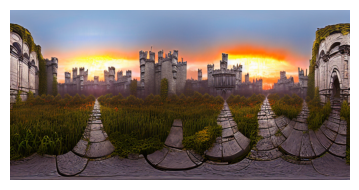

In [62]:
## PLOTTING AND SAVING WITH INPAINTING
import matplotlib.pyplot as plt
def plots_images(images):
    num_images = len(images)
    
    # Set the figure size dynamically based on the number of images
    plt.figure(figsize=(15, 2 * num_images))  # Adjust height based on number of images

    for i, img in enumerate(images):
        plt.subplot(num_images, 1, i + 1)  # Create a subplot for each image
        plt.imshow(img)
        plt.axis('off')  # Hide axes
    
    plt.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.show()

def save_images(images, directory="panorama_outputs"):
    # Create directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)

    for i, img in enumerate(images):
        # Save each image with a unique name
        img_path = os.path.join(directory, f"output_image_sdv1_5_{i+4}.png")
        img.save(img_path, "PNG")
    print(f"Saved {len(images)} images to '{directory}' directory.")


save_images(output_images)
plots_images(output_images)

The new images! Hopefully the quality improved thanks to the finetuning process. You can play with the number of epochs to see how the fine-tuning process impacts the final output 💪

In [63]:
del base_pipe
del output_images